# Best Playing XI Selection for Football team through Data Science Techniques

# Data Extraction

We have developed web crawlers scripts to scrape fifa players data from sofifa.com using python library Scrapy.

Source code available at:
> https://github.com/tushartanwar/scrapy_web_scraper

# Data Cleaning, Normalization & Data Loading

### This section contains the following:
- Methods to **clean** the scraped data.
- **De-duping** of data.
- **Transformation** and **conversion** of data.
- **Normalization** of data into different sqlite3 tables.
- **Creation** of sqlite3 tables.
- **Loading** the cleaned data into the target tables.

**We have logically divided the scraped data into the following schema tables:<br>**
- player_personal_info<br>
- player_club_info<br>
- player_country_info<br>
- player_financial_info<br>
- player_attributes_info<br>
- player_positions_info

In [1]:
from functools import reduce
from pandas import DataFrame
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sqlite3 import Error
import re

%matplotlib inline

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split

In [3]:
import pulp 

In [82]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import requests
from io import BytesIO

In [4]:
db_filename = 'sofifa.db'        # Sqlite3 DB Filename
data_csv = 'sofifa_players.csv'  # Scraped data file (csv)

# Function to connect sqlite3
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)
        
    return conn


# Function to execute sql commands in sqlite3
def execute_query(connection, query):
    curr = connection.cursor()
    curr.execute(query)


# Function to convert money values to the lowest form.
def unitary_conversion(in_val):
    if 'M' in in_val:
        return float(re.sub('[^0-9.]','',in_val))*10000
    elif 'K' in in_val:
        return float(re.sub('[^0-9.]','',in_val))*1000
    else:
        return float(re.sub('[^0-9.]','',in_val))


# Function to compute the sums of the attributes
def compute_stats(in_rec):
    try:
        calc = int(eval(in_rec))
    except:
        calc = in_rec
    return calc


# Function to strip lbs from the weight
def strip_lbs(in_rec):
    return in_rec.strip('lbs')


# Function to convert height into cms
def height_to_cm(in_rec):
    feet,inches = in_rec.split('\'')
    in_cms = round(int(feet)*30.48+int(inches.strip('"'))*2.54,2)
    return in_cms

In [5]:
# Function to execute sql commands in sqlite3
def execute_query(connection, query):
    curr = connection.cursor()
    q_result = curr.execute(query)
    return q_result.fetchall()
# Function to read sql results as pandas dataframe
def read_sql_as_pandas_df(connection, query):
    data_df = pd.read_sql_query(query,connection)
    return data_df

In [6]:
# Reading scraped data in csv using Pandas
all_data = pd.read_csv(data_csv,dtype='str')

# Relacing all the newline characters with empty string.
all_data = all_data.replace('\n','')

# Dropping all the duplicates and keeping the first records out of the two or many duplicates.
all_data.drop_duplicates(keep='first',inplace=True)

In [7]:
# Converting the wage and value of the player to the lowest unit.
all_data['value'] = all_data['value'].apply(unitary_conversion)
all_data['wage'] = all_data['wage'].apply(unitary_conversion)

In [8]:
# Evaluating the attributes of all the players.
all_data[['LS', 'ST', 'RS',
          'LW', 'LF', 'CF', 
          'RF', 'RW', 'LAM',
          'CAM', 'RAM', 'LM',
          'LCM', 'CM', 'RCM',
          'RM', 'LWB', 'LDM',
          'CDM','RDM', 'RWB',
          'LB', 'LCB', 'CB',
          'RCB', 'RB']] = all_data[['LS', 'ST', 'RS',
                                    'LW', 'LF', 'CF', 
                                    'RF', 'RW', 'LAM',
                                    'CAM', 'RAM', 'LM',
                                    'LCM', 'CM', 'RCM',
                                    'RM', 'LWB', 'LDM',
                                    'CDM','RDM', 'RWB',
                                    'LB', 'LCB', 'CB',
                                    'RCB', 'RB']].applymap(compute_stats)

In [9]:
# Stripping lbs from the weight
all_data['player_weight_lbs'] = all_data['player_weight'].apply(strip_lbs)

In [10]:
# Converting height into cms
all_data['player_height_cms'] = all_data['player_height'].apply(height_to_cm)

In [11]:
# Renaming some columns
all_data.rename(columns = {'Heading Accuracy':'heading_accuracy'
                          ,'Short Passing':'short_passing'
                          ,'FK Accuracy':'fk_accuracy'
                          ,'Shot Power':'shot_power'
                          ,'Long Passing':'long_passing'
                          ,'Ball Control':'ball_control'
                          ,'Sprint Speed':'sprint_speed'
                          ,' GK Diving':'gk_diving'
                          ,' GK Handling':'gk_handling'
                          ,' GK Kicking':'gk_kicking'
                          ,' GK Positioning':'gk_positioning'
                          ,' GK Reflexes':'gk_reflexes'
                          ,'Crossing':'crossing'
                          ,'Finishing':'finishing'
                          ,'Volleys':'volleys'
                          ,'Dribbling':'dribbling'
                          ,'Curve':'curve'
                          ,'Acceleration':'acceleration'
                          ,'Agility':'agility'
                          ,'Reactions':'reactions'
                          ,'Balance':'balance'
                          ,'Jumping':'jumping'
                          ,'Stamina':'stamina'
                          ,'Strength':'strength'
                          ,'Aggression':'aggression'
                          ,'Interceptions':'interceptions'
                          ,'Positioning':'positioning'
                          ,'Vision':'vision'
                          ,'Penalties':'penalties'
                          ,'Defensive Awareness':'defensive_awareness'
                          ,'Standing Tackle':'standing_tackle'
                          ,'Sliding Tackle':'sliding_tackle'
                          ,'Long Shots':'long_shots'}, inplace=True)

In [12]:
# Create statements for the sqlite3 tables.

# TABLE: player_personal_info
sql_create_player_personal_info = '''
CREATE TABLE IF NOT EXISTS player_personal_info 
(
     player_id          INTEGER NOT NULL PRIMARY KEY
    ,player_name        TEXT NOT NULL
    ,player_nationality TEXT
    ,player_photo_url   TEXT
    ,player_weight_lbs  REAL
    ,player_age         INTEGER
    ,player_height_cms  REAL
    ,preferred_foot     TEXT
);
'''

# TABLE: player_club_info
sql_create_player_club_info = '''
CREATE TABLE IF NOT EXISTS player_club_info
(
     player_id                      INTEGER NOT NULL PRIMARY KEY
    ,club_name                      TEXT
    ,club_flag_url                  TEXT
    ,club_playing_position          TEXT
    ,club_jersey_number             INTEGER
    ,current_club_joined_dt         TEXT
    ,current_club_contract_valid_yr INTEGER
    ,FOREIGN KEY(player_id)         
        REFERENCES player_personal_info(player_id)
);
'''

# TABLE: player_country_info
sql_create_player_country_info = '''
CREATE TABLE IF NOT EXISTS player_country_info
(
     player_id                INTEGER NOT NULL PRIMARY KEY
    ,country                  TEXT
    ,country_flag_url         TEXT
    ,country_playing_position TEXT
    ,country_jersey_number    INTEGER
    ,FOREIGN KEY(player_id)
        REFERENCES player_personal_info(player_id)
);
'''

# TABLE: player_financial_info
sql_create_player_financial_info = '''
CREATE TABLE IF NOT EXISTS player_financial_info
(
     player_id               INTEGER NOT NULL PRIMARY KEY
    ,value                   REAL
    ,wage                    REAL
    ,FOREIGN KEY(player_id)
        REFERENCES player_personal_info(player_id)
);
'''

# TABLE: player_attributes_info
sql_create_player_attributes_info = '''
CREATE TABLE IF NOT EXISTS player_attributes_info
(
     player_id                  INTEGER NOT NULL PRIMARY KEY
    ,weak_foot                  INTEGER
    ,international_reputation   INTEGER
    ,skill_moves                INTEGER
    ,overall_rating             INTEGER
    ,potential                  INTEGER
    ,crossing                   INTEGER
    ,finishing                  INTEGER
    ,heading_accuracy           INTEGER
    ,short_passing              INTEGER
    ,volleys                    INTEGER
    ,dribbling                  INTEGER
    ,curve                      INTEGER
    ,fk_accuracy                INTEGER
    ,long_passing               INTEGER
    ,ball_control               INTEGER
    ,acceleration               INTEGER
    ,sprint_speed               INTEGER
    ,agility                    INTEGER
    ,reactions                  INTEGER
    ,balance                    INTEGER
    ,shot_power                 INTEGER
    ,jumping                    INTEGER
    ,stamina                    INTEGER
    ,strength                   INTEGER
    ,long_shots                 INTEGER
    ,aggression                 INTEGER
    ,interceptions              INTEGER
    ,positioning                INTEGER
    ,vision                     INTEGER
    ,penalties                  INTEGER
    ,defensive_awareness        INTEGER
    ,standing_tackle            INTEGER
    ,sliding_tackle             INTEGER
    ,gk_diving                  INTEGER
    ,gk_handling                INTEGER
    ,gk_kicking                 INTEGER
    ,gk_positioning             INTEGER
    ,gk_reflexes                INTEGER
    ,FOREIGN KEY(player_id)
        REFERENCES player_personal_info(player_id)
);
'''

# TABLE: player_positions_info
sql_create_player_positions_info = '''
CREATE TABLE IF NOT EXISTS player_positions_info
(
      player_id     INTEGER NOT NULL PRIMARY KEY
     ,ls            INTEGER
     ,st            INTEGER
     ,rs            INTEGER
     ,lw            INTEGER
     ,lf            INTEGER
     ,cf            INTEGER
     ,rf            INTEGER
     ,rw            INTEGER
     ,lam           INTEGER
     ,cam           INTEGER
     ,ram           INTEGER
     ,lm            INTEGER
     ,lcm           INTEGER
     ,cm            INTEGER
     ,rcm           INTEGER
     ,rm            INTEGER
     ,lwb           INTEGER
     ,ldm           INTEGER
     ,cdm           INTEGER
     ,rdm           INTEGER
     ,rwb           INTEGER
     ,lb            INTEGER
     ,lcb           INTEGER
     ,cb            INTEGER
     ,rcb           INTEGER
     ,rb            INTEGER
     ,FOREIGN KEY(player_id)
        REFERENCES player_personal_info(player_id)
);
'''

In [13]:
# Executing the create table commands one by one in a loop.
tables_list = [sql_create_player_personal_info
              ,sql_create_player_club_info
              ,sql_create_player_country_info
              ,sql_create_player_financial_info
              ,sql_create_player_attributes_info
              ,sql_create_player_positions_info]

for table in tables_list:
    conn = create_connection(db_filename)
    try:
        execute_query(conn,table)
    except Error as e:
        print(e)
    finally:
        conn.commit()
        conn.close()

In [14]:
# Extracting each individual table columns from the un-normalized dataframe to the normalized dataframes.

# TABLE: player_personal_info
player_personal_info = all_data[['player_id'
                                ,'player_name'
                                ,'player_nationality'
                                ,'player_photo_url'
                                ,'player_weight_lbs'
                                ,'player_age'
                                ,'player_height_cms'
                                ,'preferred_foot']]

# TABLE: player_club_info
player_club_info = all_data[['player_id'
                            ,'club_name'
                            ,'club_flag_url'
                            ,'club_playing_position'
                            ,'club_jersey_number'
                            ,'current_club_joined_dt'
                            ,'current_club_contract_valid_yr']]

# TABLE: player_country_info
player_country_info = all_data[['player_id'
                               ,'country'
                               ,'country_flag_url'
                               ,'country_playing_position'
                               ,'country_jersey_number']]

# TABLE: player_financial_info
player_financial_info = all_data[['player_id'
                                 ,'value'
                                 ,'wage']]

# TABLE: player_attributes_info
player_attributes_info = all_data[['player_id'
                                  ,'weak_foot'
                                  ,'international_reputation'
                                  ,'skill_moves'
                                  ,'overall_rating'
                                  ,'potential'
                                  ,'crossing'
                                  ,'finishing'
                                  ,'heading_accuracy'
                                  ,'short_passing'
                                  ,'volleys'
                                  ,'dribbling'
                                  ,'curve'
                                  ,'fk_accuracy'
                                  ,'long_passing'
                                  ,'ball_control'
                                  ,'acceleration'
                                  ,'sprint_speed'
                                  ,'agility'
                                  ,'reactions'
                                  ,'balance'
                                  ,'shot_power'
                                  ,'jumping'
                                  ,'stamina'
                                  ,'strength'
                                  ,'long_shots'
                                  ,'aggression'
                                  ,'interceptions'
                                  ,'positioning'
                                  ,'vision'
                                  ,'penalties'
                                  ,'defensive_awareness'
                                  ,'standing_tackle'
                                  ,'sliding_tackle'
                                  ,'gk_diving'
                                  ,'gk_handling'
                                  ,'gk_kicking'
                                  ,'gk_positioning'
                                  ,'gk_reflexes']]

# TABLE: player_positions_info
player_positions_info = all_data[['player_id'
                                 ,'LS'
                                 ,'ST'
                                 ,'RS'
                                 ,'LW'
                                 ,'LF'
                                 ,'CF'
                                 ,'RF'
                                 ,'RW'
                                 ,'LAM'
                                 ,'CAM'
                                 ,'RAM'
                                 ,'LM'
                                 ,'LCM'
                                 ,'CM'
                                 ,'RCM'
                                 ,'RM'
                                 ,'LWB'
                                 ,'LDM'
                                 ,'CDM'
                                 ,'RDM'
                                 ,'RWB'
                                 ,'LB'
                                 ,'LCB'
                                 ,'CB'
                                 ,'RCB'
                                 ,'RB']]

In [15]:
# Loading data into the respective tables from the pandas dataframe.
tables_list = ['player_personal_info'
              ,'player_club_info'
              ,'player_country_info'
              ,'player_financial_info'
              ,'player_attributes_info'
              ,'player_positions_info']

table_data_df = [player_personal_info
                ,player_club_info
                ,player_country_info
                ,player_financial_info
                ,player_attributes_info
                ,player_positions_info]

for table,data in zip(tables_list,table_data_df):
    conn = create_connection(db_filename)
    try:
        data.to_sql(name=table,con=conn,index=False,if_exists="append")
    except Error as e:
        print(e)
    finally:
        conn.commit()
        conn.close()

# Data Analysis and Data Visualization

### Data Analysis on Clubs team formation

In [16]:
conn = create_connection(db_filename)

sql = """ SELECT player_club_info.player_id, club_name, player_name, club_playing_position, value, overall_rating
FROM player_club_info join player_financial_info on player_club_info.player_id = player_financial_info.player_id
join player_personal_info on player_personal_info.player_id = player_club_info.player_id 
join player_attributes_info on player_personal_info.player_id = player_attributes_info.player_id 
"""

df = read_sql_as_pandas_df(conn, sql)

In [17]:
df

,player_id,club_name,player_name,club_playing_position,value,overall_rating
0,16,KAS Eupen,Luis García,LCM,750000.0,71
1,27,Coventry City,J. Cole,CAM,11000.0,71
2,41,Vissel Kobe,Iniesta,CAM,110000.0,83
3,80,Fenerbahçe SK,E. Belözoğlu,LDM,33000.0,78
4,164,Padova,G. Pinzi,RES,240000.0,70
...,...,...,...,...,...,...
19660,253664,Shonan Bellmare,H. Fukushima,RES,140000.0,55
19661,253675,Jaguares de Córdoba,D. Ciro,RES,80000.0,53
19662,253693,Borussia Mönchengladbach,C. Noß,RES,750000.0,63
19663,253695,SK Slavia Praha,L. Takács,RES,11000.0,68


In [18]:
club = df.groupby('club_name', sort=True).sum().reset_index()

In [19]:
club

,club_name,player_id,value,overall_rating
0,SSV Jahn Regensburg,5842065,10199000.0,1682
1,1. FC Heidenheim 1846,6348008,5448000.0,1828
2,1. FC Kaiserslautern,7330017,15786000.0,2043
3,1. FC Köln,6877424,4613000.0,2287
4,1. FC Magdeburg,5537774,13365000.0,1551
...,...,...,...,...
876,Çaykur Rizespor,6732370,7987000.0,2029
877,Örebro SK,4601283,5760000.0,1183
878,Östers IF,199067,0.0,59
879,Östersunds FK,5443627,10465000.0,1474


#### Index for playing position in football field

In [20]:
index_playing_position = ['LS', 'ST', 'RS', 'LF', 'CF', 'RF', 'LAM', 'CAM', 'RAM', 'LW',  'RW', 'LM', 'CM', 'RM', 'LCM', 'RCM', 'LDM', 'CDM','RDM', 'RWB', 'LWB', 'LB', 'CB', 'RB', 'LCB', 'RCB', 'GK']

#### Top 5 Clubs which spends most to players

In [21]:
top_clubs = []

top_paying_clubs = club.nlargest(5, 'value')['club_name'].tolist()

for club_name in top_paying_clubs:
    c_name = df[(df['club_name'] == club_name) & (df['club_playing_position'].isin(index_playing_position)) & (df['value'] != 0)]
    idx = c_name.groupby(['club_playing_position'])['value'].transform(max) == c_name['value']
    c_name = c_name[idx]
    c_name = DataFrame(c_name['player_name'].tolist(), index = c_name['club_playing_position'])
    top_clubs.append(c_name)
    
top_paying_club_players = reduce(lambda left, right: pd.merge(left,right, left_index=True, right_index=True,
                                            how='outer'), top_clubs)
top_paying_club_players.columns = top_paying_clubs

In [22]:
top_paying_club_players

,Waasland-Beveren,Ipswich Town,1. FC Kaiserslautern,Wisła Kraków,ADO Den Haag
club_playing_position,,,,,
CAM,X. Emmers,NaN,S. Skarlatidis,K. Wojtkowski,A. El Khayati
CDM,NaN,NaN,NaN,NaN,J. Goossens
GK,N. Jackers,T. Holý,L. Grill,Julián Cuesta,L. Koopmans
LB,D. Foulon,M. Kenlock,J. Sternberg,M. Sadlok,NaN
LCB,A. Vukotić,L. Chambers,J. Matuwila,Fran Vélez,S. Pinas
LCM,NaN,F. Downes,NaN,NaN,D. Malone
LDM,D. Jubitana,NaN,C. Sickinger,V. Basha,NaN
LM,B. Badibanga,G. Edwards,F. Pick,M. Mak,NaN
LS,NaN,K. Jackson,NaN,NaN,NaN


#### Top 5 Clubs which has players with higher rating

In [23]:
top_clubs = []

top_rating_clubs = club.nlargest(5, 'overall_rating')['club_name'].tolist()

for club_name in top_rating_clubs:
    c_name = df[(df['club_name'] == club_name) & (df['club_playing_position'].isin(index_playing_position))]
    idx = c_name.groupby(['club_playing_position'])['overall_rating'].transform(max) == c_name['overall_rating']
    c_name = c_name[idx]
    c_name = DataFrame(c_name['player_name'].tolist(), index = c_name['club_playing_position'])
    c_name = c_name.loc[~c_name.index.duplicated(keep='first')]
    top_clubs.append(c_name)
    
top_rating_club_players = reduce(lambda left, right: pd.merge(left,right, left_index=True, right_index=True,
                                            how='outer'), top_clubs)
top_rating_club_players.columns = top_rating_clubs

In [24]:
top_rating_club_players

,Olympiacos CFP,Manchester United,Atlético Madrid,Paris Saint-Germain,Juventus
club_playing_position,,,,,
CAM,M. Valbuena,Juan Mata,NaN,Neymar Jr,NaN
CDM,NaN,NaN,NaN,NaN,M. Pjanić
GK,José Sá,De Gea,J. Oblak,K. Navas,W. Szczęsny
LB,K. Tsimikas,L. Shaw,Filipe Luís,Bernat,Alex Sandro
LCB,Y. Meriah,H. Maguire,J. Giménez,Thiago Silva,M. de Ligt
LCM,E. Cambiasso,NaN,Saúl,M. Verratti,B. Matuidi
LDM,A. Bouchalakis,P. Pogba,NaN,NaN,NaN
LM,G. Masouras,D. James,T. Lemar,NaN,P. Nedved
LS,NaN,NaN,João Félix,NaN,NaN


#### Player's Analysis of their value with respect to the playing position

In [25]:
# Function to check player belongs to which group among GK,DEF,MID,FWD

def group_player_position(position):
        
        if position in ['GK']:     
            return 'GK'
        
        elif position in ['LWB' , 'LB' , 'CB' , 'RB' , 'RWB' , 'LCB', 'RCB' ] :
            return 'DEF'
        
        elif position in ['LM' , 'CDM' , 'CM' , 'CAM' , 'RM' , 
                         'LAM' ,'LCM' ,'LDM' , 'RAM' , 'RCM' ,'RDM', 'RW' , 'LW'] :
            return 'MID'
    
        elif position in  ['CF' , 'ST' ,'LF', 'LS' , 'RF' , 'RES' , 'RS']:
            return 'FWD'

#### Boxplot representing player values of all players at their current playing positions in their respective clubs.

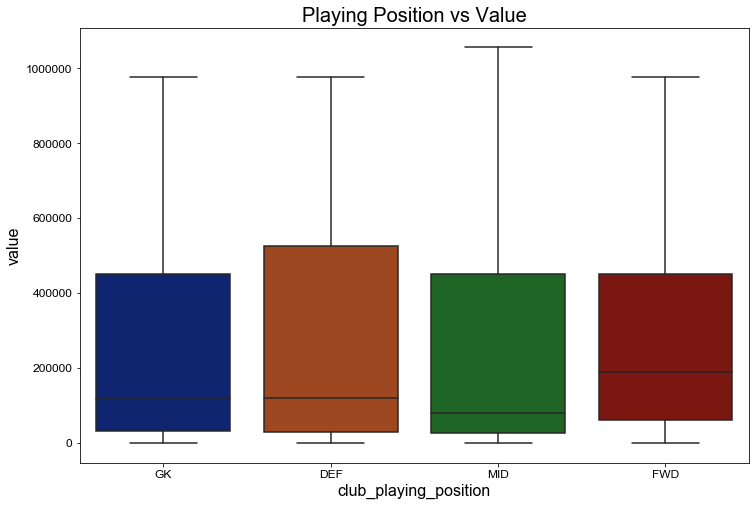

In [26]:
# Representing Graph of player's playing position vs value.

db_file='sofifa.db'

conn = create_connection(db_file)

read_df = pd.read_sql_query("""Select
                                 player_club_info.club_playing_position, 
                                 player_financial_info.value from player_club_info 
                                 inner join player_financial_info 
                                 on player_club_info.player_id = player_financial_info.player_id 
                                 where player_club_info.club_playing_position is not null and 
                                 player_financial_info.value is not null;""",conn)
                                 

    
complete_df = read_df[['club_playing_position','value']]
complete_df = complete_df[complete_df.club_playing_position != 'SUB']


complete_df['club_playing_position'] = complete_df['club_playing_position'].apply(group_player_position)

ordering_list = ['GK' , 'DEF' ,'MID' , 'FWD']

title = 'Playing Position vs Value'

fig, ax = plt.subplots(figsize=(12, 8))

sns.set(style='dark', palette='dark', color_codes=True)

ax.axes.set_title(title, fontsize=20)
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('', fontsize = 16)
plt.yticks(fontsize='12')
plt.xticks(fontsize='12')

sns.boxplot(x = 'club_playing_position' , y = 'value' ,data = complete_df, order = ordering_list)

conn.close()

In [27]:
#Finding top 10 positions of every group of positions.

db_file='sofifa.db'

conn = create_connection(db_file)

read_pos_data = pd.read_sql_query(""" Select player_personal_info.player_name,
                        player_club_info.club_playing_position,
                        player_attributes_info.overall_rating from player_personal_info
                        left outer join player_club_info on
                        player_personal_info.player_id = player_club_info.player_id
                        left outer join player_attributes_info
                        on player_club_info.player_id = player_attributes_info.player_id
                        where player_club_info.club_playing_position is not null ;""" , conn)

DEF = ['LWB' , 'LB' , 'CB' , 'RB' , 'RWB' , 'LCB', 'RCB' ]

MID  = ['LM' , 'CDM' , 'CM' , 'CAM' , 'RM' , 
                         'LAM' ,'LCM' ,'LDM' , 'RAM' , 'RCM' ,'RDM', 'RW' , 'LW']

FWD = ['CF' , 'ST' ,'LF', 'LS' , 'RF' , 'RES' , 'RS']

def_data = {}
mid_data = {}
gk_data = {}
fwd_data = {}

# Top 10 positions for GK
GK_df = read_pos_data.loc[read_pos_data.club_playing_position == 'GK']

GK_df = GK_df.sort_values(by = 'overall_rating' , ascending = False)

GK_df = GK_df.iloc[0:10]
    
GK_df = GK_df['player_name'].tolist()

gk_data = {'GK' : GK_df}

# Top 10 positions in DEF 
for element in DEF :
    
    DEF_df = read_pos_data.loc[read_pos_data.club_playing_position == element]

    DEF_df = DEF_df.sort_values(by = 'overall_rating' , ascending = False)

    DEF_df = DEF_df.iloc[0:10]
    
    DEF_df = DEF_df['player_name'].tolist()
    
    def_data[element] = DEF_df
    
# Top 10 positions in MID   
for element in MID :
    
    MID_df = read_pos_data.loc[read_pos_data.club_playing_position == element]

    MID_df = MID_df.sort_values(by = 'overall_rating' , ascending = False)

    MID_df = MID_df.iloc[0:10]
    
    MID_df = MID_df['player_name'].tolist()
    
    mid_data[element] = MID_df
    
# Top 10 positions in FWD
for element in FWD :
    
    FWD_df = read_pos_data.loc[read_pos_data.club_playing_position == element]

    FWD_df = FWD_df.sort_values(by = 'overall_rating' , ascending = False)

    FWD_df = FWD_df.iloc[0:10]
    
    FWD_df = FWD_df['player_name'].tolist()
    
    fwd_data[element] = FWD_df
    
    
mid_df = pd.DataFrame(mid_data)  

def_df = pd.DataFrame(def_data) 

gk_df = pd.DataFrame(gk_data)

fwd_df = pd.DataFrame(fwd_data)


display(gk_df)
display(def_df)
display(mid_df)
display(fwd_df)


,GK
0,J. Oblak
1,M. ter Stegen
2,De Gea
3,Alisson
4,Ederson
5,M. Neuer
6,S. Handanovič
7,T. Courtois
8,H. Lloris
9,K. Navas


,LWB,LB,CB,RB,RWB,LCB,RCB
0,M. Halstenberg,Jordi Alba,S. de Vrij,P. Lahm,K. Lala,V. van Dijk,D. Godín
1,Jonny,Alex Sandro,F. Acerbi,Carvajal,L. Klostermann,Sergio Ramos,Piqué
2,R. Bertrand,Marcelo,L. Koscielny,K. Walker,M. Doherty,K. Koulibaly,Marquinhos
3,J. Willems,Filipe Luís,N. Nkoulou,Azpilicueta,Cédric,M. Hummels,L. Bonucci
4,S. March,A. Robertson,M. Hasebe,T. Alexander-Arnold,R. Rosales,Thiago Silva,K. Manolas
5,A. Oyongo,D. Alaba,S. Bender,Ricardo Pereira,Montoya,J. Vertonghen,N. Süle
6,N. Hult,Alex Telles,I. Konaté,Dani Alves,H. Traoré,Fernandinho,R. Varane
7,E. Stevens,N. Tagliafico,G. Pezzella,Jesús Navas,Léo Moura,M. Škriniar,Sokratis
8,J. Silva,Grimaldo,K. Glik,Nélson Semedo,A. Souquet,J. Giménez,Pepe
9,F. Maouassa,L. Digne,C. Zapata,T. Meunier,E. Krafth,M. de Ligt,D. Djené


,LM,CDM,CM,CAM,RM,LAM,LCM,LDM,RAM,RCM,RDM,RW,LW
0,P. Aubameyang,Sergio Busquets,Luis Alberto,Neymar Jr,S. Gnabry,Q. Promes,T. Kroos,P. Pogba,H. Ziyech,K. De Bruyne,J. Kimmich,L. Messi,Cristiano Ronaldo
1,Y. Brahimi,Casemiro,Illarramendi,M. Reus,Pizzi,Renato Augusto,David Silva,Thiago,A. D'Alessandro,L. Modrić,A. Witsel,M. Salah,E. Hazard
2,K. Coman,M. Pjanić,R. Nainggolan,C. Eriksen,J. Sancho,N. Sansone,M. Verratti,Lucas Leiva,Fernando,N. Kanté,S. Milinković-Savić,Bernardo Silva,K. Mbappé
3,Felipe Anderson,Fabinho,Rúben Neves,Coutinho,José Callejón,Juninho,F. de Jong,William Carvalho,I. Fernández,Parejo,Rosberto Dourado,A. Di María,A. Griezmann
4,Canales,Rodri,L. Biglia,A. Gómez,W. Zaha,Rivaldo,Saúl,T. Delaney,Luan,Allan,A. Guardado,G. Bale,S. Mané
5,Gonçalo Guedes,Jorginho,M. Dembélé,N. Fekir,N. Pépé,M. Ninković,B. Matuidi,G. Xhaka,R. Orsolini,Koke,A. Doucouré,Douglas Costa,R. Sterling
6,T. Lemar,Fernando,L. Milivojević,M. Hamšík,E. Višća,D. Drexler,Paulinho,E. Capoue,Sebas Couteira,Bruno Fernandes,Luiz Gustavo,C. Vela,M. Depay
7,Y. Carrasco,M. Brozović,F. Neuhaus,M. Kruse,Ronaldo Cabrais,Leo Caldeirinha,João Moutinho,F. Delph,Caio Milaçar,Oscar,Y. M'Vila,Anderson Talisca,Oyarzabal
8,F. Kostić,W. Ndidi,J. Martin,G. Sigurðsson,Marlos,N. De la Cruz,G. Wijnaldum,T. Souček,K. Schindler,I. Gueye,C. Kramer,Willian,S. El Shaarawy
9,Taison,Thiago Mendes,K. Laimer,Iniesta,Mário Fernandes,V. Hernández,Danilo Pereira,L. Martínez,Nikão,J. Henderson,André Gomes,S. Berghuis,S. Bergwijn


,CF,ST,LF,LS,RF,RES,RS
0,K. Benzema,S. Agüero,N. Amiri,L. Insigne,K. Havertz,G. Chiellini,H. Kane
1,Roberto Firmino,L. Suárez,Alex Berenguer,H. Son,Iago Falqué,K. Trapp,D. Mertens
2,Guti,R. Lewandowski,N. Vlašić,Rodrigo,A. Mehmedi,J. Draxler,Iago Aspas
3,J. Correa,E. Cavani,J. Brekalo,T. Werner,G. Martínez,K. Casteels,R. Lukaku
4,H. Ben Arfa,C. Immobile,S. Igboun,F. Quagliarella,S. Kalu,C. Marchisio,J. Iličić
5,Dyego Sousa,A. Lacazette,R. Nuzzolo,D. Zapata,J. Haberer,Casillas,W. Ben Yedder
6,C. Tévez,G. Higuaín,N. De Préville,F. Ribéry,S. Arfield,A. Barzagli,Morata
7,Djaniny,Z. Ibrahimović,Fabrício,L. Martínez,Gabriel Xavier,F. Thauvin,C. Bakambu
8,M. Damsgaard,E. Džeko,V. Verre,L. López,M. Zaccagni,L. Fabiański,M. Balotelli
9,Mauro Júnior,D. Tadić,E. Barco,Jorge Molina,C. Nyman,M. Perin,Suso


#### Player's Analysis of Performance and Value with respect to their Age

In [28]:
conn = create_connection(db_filename)

In [29]:
SQL = """select player_age as age, value, overall_rating as performance
from player_personal_info 
join player_financial_info on player_personal_info.player_id = player_financial_info.player_id
join player_attributes_info on player_personal_info.player_id = player_attributes_info.player_id;"""
df = read_sql_as_pandas_df(conn, SQL)

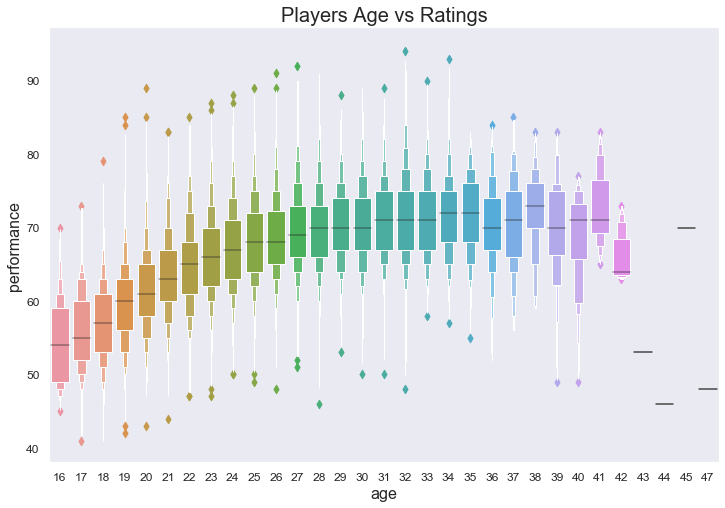

In [30]:
fig, ax = plt.subplots(figsize=(12, 8)) 
sns.set(style='darkgrid', palette='dark', color_codes=True)
ax.axes.set_title('Players Age vs Ratings', fontsize=20)
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('', fontsize = 16)
plt.yticks(fontsize='12') 
plt.xticks(fontsize='12')
a = plt.setp(ax.get_xticklabels(), rotation=0)
sns.boxenplot(df.age, df.performance)

> Median for the age group tends to increase as Age increases

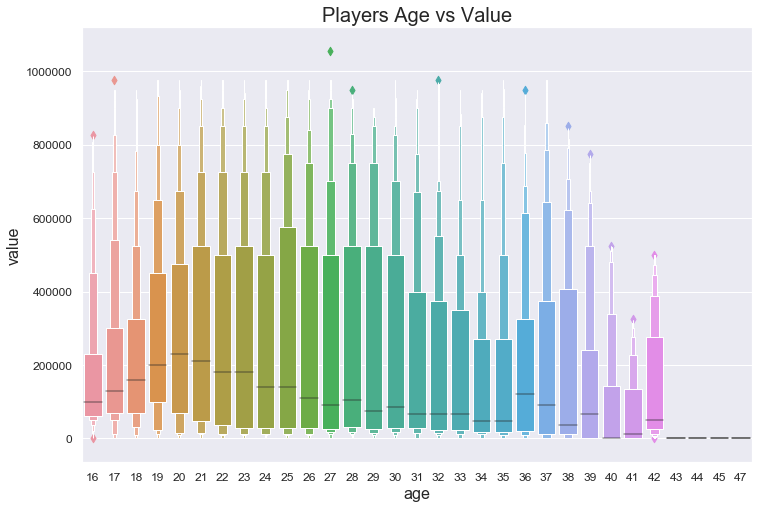

In [31]:
fig, ax = plt.subplots(figsize=(12, 8)) 
sns.set(style='darkgrid', palette='dark', color_codes=True)
ax.axes.set_title('Players Age vs Value', fontsize=20)
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('', fontsize = 16)
plt.yticks(fontsize='12') 
plt.xticks(fontsize='12')
a = plt.setp(ax.get_xticklabels(), rotation=0)
sns.boxenplot(df.age, df.value)


> Value range seems to be wide for younger player compared to the older players

In [32]:
def value_range(value):
    v_range = value // 100000
    v_dict = {0:'<10M', 1:'10-20M', 2:'20-30M', 3:'30-40M', 4:'40-50M', 5:'50-60M', 6:'60-70M', 7:'70-80M', 8:'80-90M', 9:'90-100M', 10:'>100M'} 
    return v_dict.get(v_range, None)

df['value_range'] = df['value'].apply(value_range)

Text(0.5, 1, "Player's Age vs Performance vs Value")

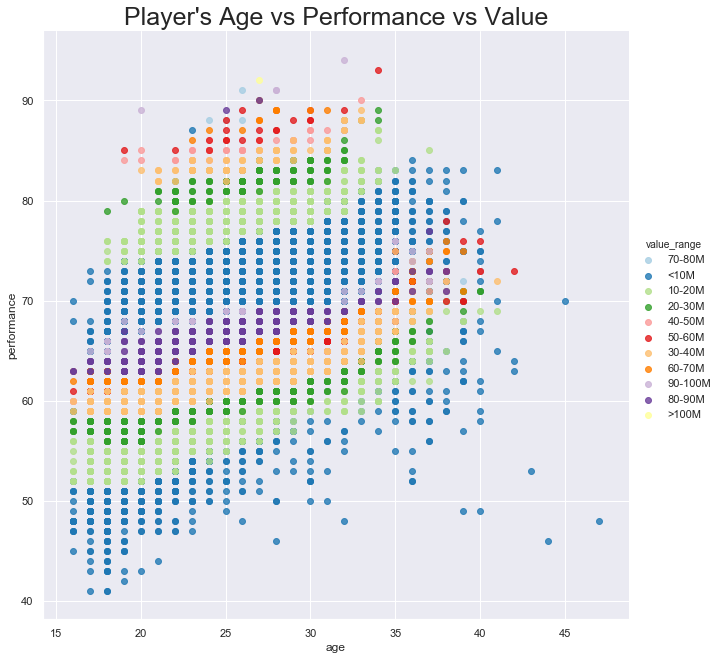

In [33]:
sns.lmplot('age', 'performance', data = df, hue='value_range', fit_reg=False, height = 9, palette = 'Paired' )
ax = plt.gca()
ax.set_title("Player's Age vs Performance vs Value", fontsize=25)

> Club tends to spend more on Younger players despite having lower overall rating. Neymar Jr. has highest value with rating above 90

#### Correlation Plot between all the Player Attributes.

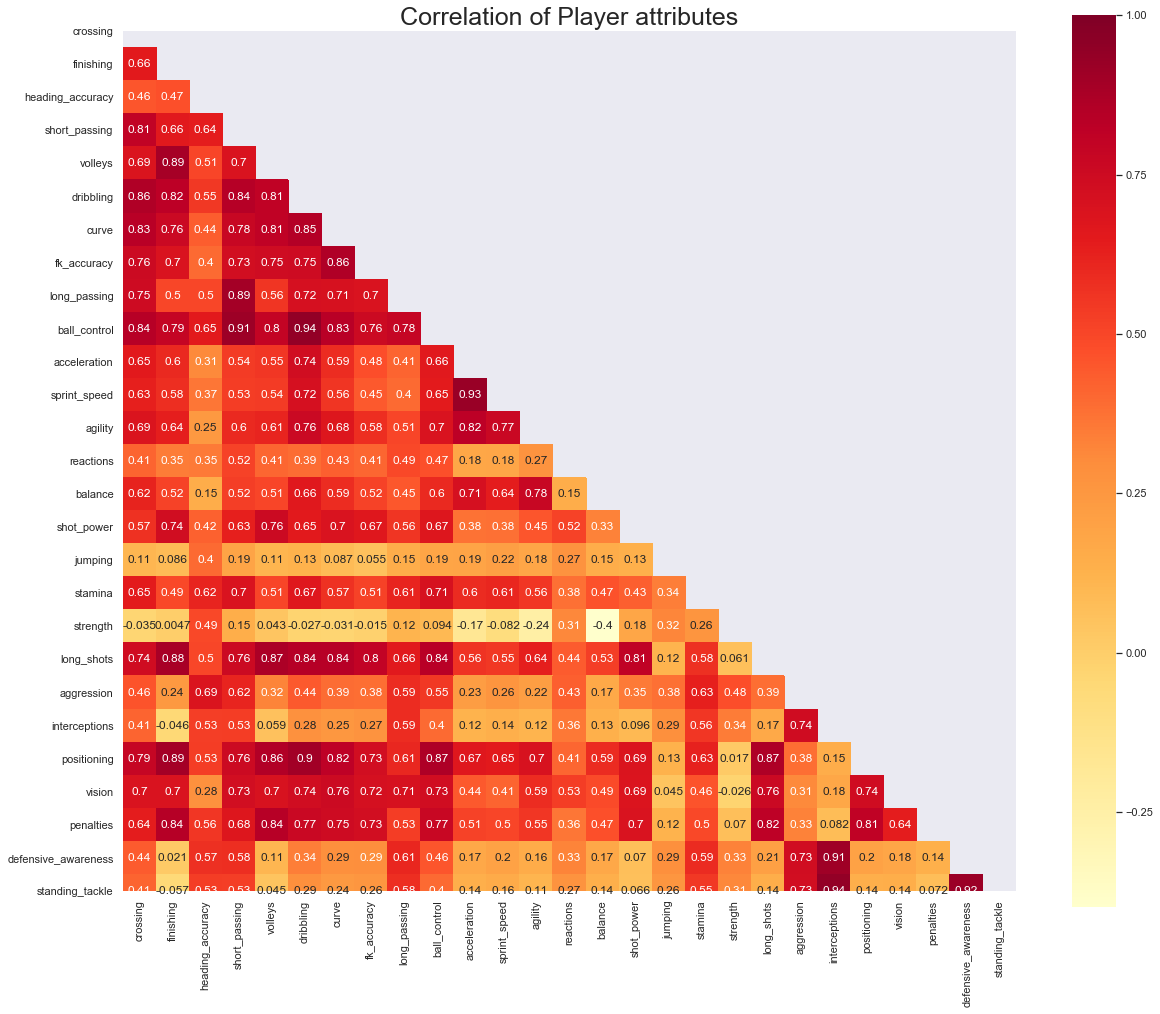

In [34]:
#Creating a Correlation plot of all player attributes

db_file='sofifa.db'

conn = create_connection(db_file)

read_attributes_data = pd.read_sql_query(""" Select crossing
        ,finishing
        ,heading_accuracy
        ,short_passing
        ,volleys
        ,dribbling                                  
        ,curve  
        ,fk_accuracy
        ,long_passing                          
        ,ball_control                         
        ,acceleration                          
        ,sprint_speed                         
        ,agility                         
        ,reactions                         
        ,balance                          
        ,shot_power                         
        ,jumping                         
        ,stamina                         
        ,strength                          
        ,long_shots                         
        ,aggression                          
        ,interceptions                          
        ,positioning                         
        ,vision                          
        ,penalties                          
        ,defensive_awareness                         
        ,standing_tackle from player_attributes_info; """ , conn)

read_attributes_data

f, ax = plt.subplots(figsize=(20, 20))

ax.set_xlabel('', fontsize=16)
ax.set_ylabel('', fontsize = 16)

plt.title('Correlation of Player attributes' , size = 25)

mask = np.zeros_like(read_attributes_data.corr(), dtype=np.bool)

mask[np.triu_indices_from(mask)] = True

sns.heatmap(read_attributes_data.corr(), mask=mask, linewidths=0,vmax=1.0,
            square=True, cmap = 'YlOrRd', linecolor='black', 
            annot=True ,cbar=True,cbar_kws={"shrink": .82})


### BMI vs Strength/Stamina
This graph tries to explain the relation of player strength/Stamina on their BMI. <br>
- **Formula used to calculate BMI** : 703 * ( weight[in lbs] / ( height[in inches] ^ 2 ))

In [35]:
# SQL statement to fetch the strength, stamina and BMI of the player from the sqlite3 tables.
sql_select_bmi_strength = '''
SELECT
     a.player_id
    ,a.player_name
    ,a.player_nationality
    ,a.player_photo_url
    ,a.player_weight_lbs
    ,a.player_age
    ,a.player_height_cms
    ,ROUND(703*((a.player_weight_lbs)/((a.player_height_cms*0.39)*(a.player_height_cms*0.39))),2) AS bmi
    ,b.strength
    ,b.stamina
    ,b.agility
    ,b.sprint_speed
    ,b.overall_rating
FROM player_personal_info a
LEFT OUTER JOIN player_attributes_info b ON (a.player_id=b.player_id)
WHERE b.strength IS NOT NULL
AND   b.stamina IS NOT NULL
AND   b.agility IS NOT NULL
AND   b.sprint_speed IS NOT NULL
AND   b.overall_rating IS NOT NULL
;
'''

In [36]:
# Calling function to create SQLite3 connection and executing the sql statement to give output as a pandas dataframe.
conn = create_connection(db_filename)
fetch_df = read_sql_as_pandas_df(conn,sql_select_bmi_strength)
conn.close()

### BMI vs Strength

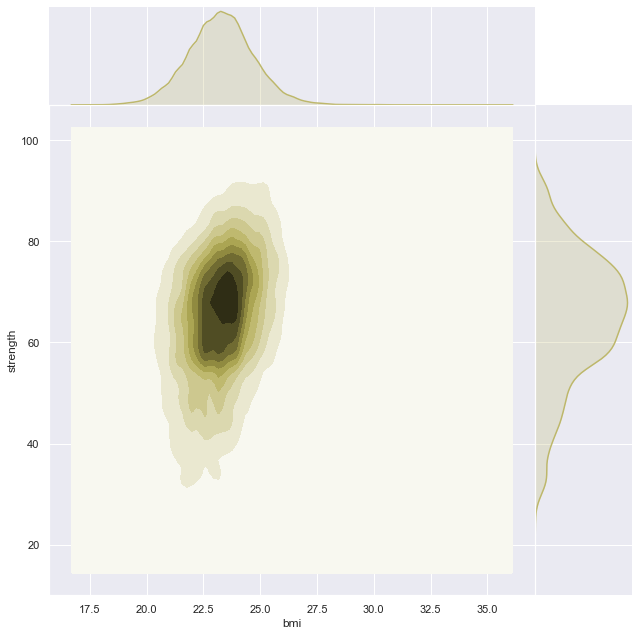

In [37]:
# Using sns jointplot with kde
sns.jointplot(kind='kde', x=fetch_df['bmi'], y=fetch_df['strength'], space=0, height=9, color='darkkhaki')

> The above graph depicts the concentration of players with strength between 60 to 80 to lie in the BMI range of 21 to 23.

### BMI vs Stamina

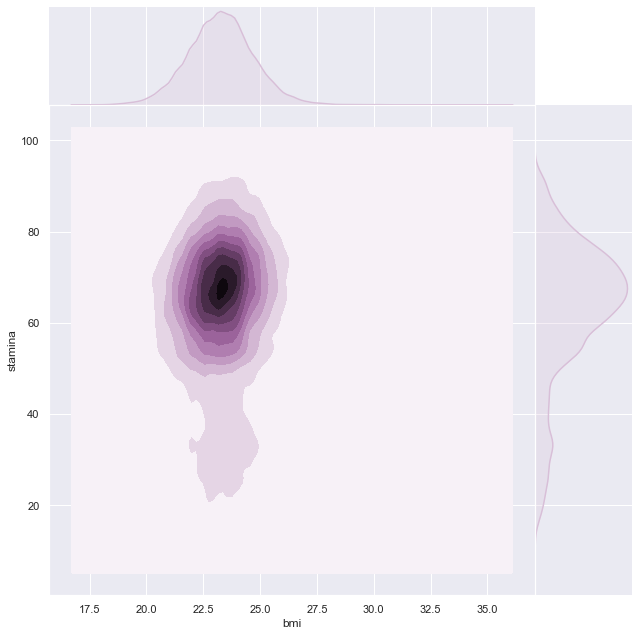

In [38]:
# Using sns jointplot with kde
sns.jointplot(kind='kde', x=fetch_df['bmi'], y=fetch_df['stamina'], space=0, height=9, color='thistle')

> The above graph depicts the concentration of players with stamina between 60 to 80 to lie in the BMI range of 22 to 25.

### Strength vs Stamina vs Overall Rating

We have seen the impact of BMI on strength and stamina. Now, we will be analyzing how strength and stamina are related to each other. Is it necessary that players with higher stamina has higher strength or vice versa? Let's find out now. <br>

We have also categorized the player in different medal leagues as per their overall rating just to see the distribution of strength and stamina of players accross different medal leagues. <br>

Below is the logic for medal leagues distribution:
- Player with overall rating less than 60 has been assigned **'Bronze'**
- Player with overall rating between 60 and 65 has been assigned **'Silver'**
- Player with overall rating between 65 and 70 has been assigned **'Gold'**
- Player with overall rating greater than 70 has been assigned **'Platinum'**

In [39]:
# Function to distribute players amongst different medal categories.
def medal_category(data_rating):
    if data_rating <= 60:
        return 'Bronze'
    elif 60 < data_rating <= 65:
        return 'Silver'
    elif 65 < data_rating <= 70:
        return 'Gold'
    elif data_rating > 70:
        return 'Platinum'

In [40]:
# Applying the function to categorize players as per their overall rating.
fetch_df['player_medal'] = fetch_df['overall_rating'].apply(medal_category)

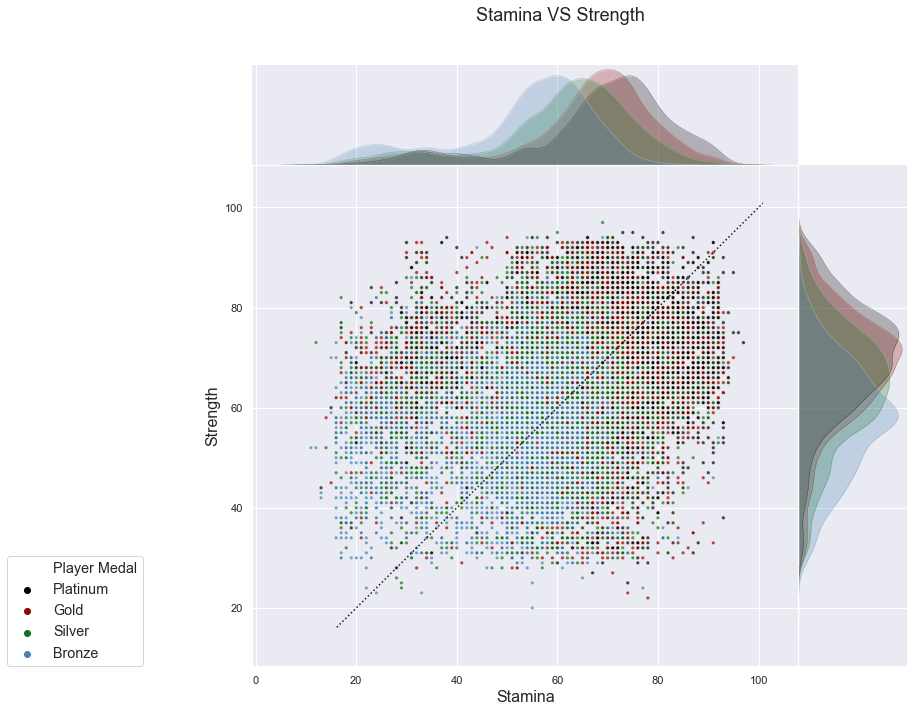

In [41]:
# Selecting medal category color palatte
medal_palette=dict({'Platinum':'black','Gold':'r','Silver':'g','Bronze':'steelblue'})

# Initiating a JointGrid so that a plot can be placed in it.
g = sns.JointGrid(x=fetch_df['stamina'], y=fetch_df['strength'], height=10, space=0)

# Plotting the scatterplot showing relation between Strength and Stamina
g = g.plot_joint(sns.scatterplot, hue=fetch_df['player_medal'].rename('Player Medal'), s=15, alpha=.7, palette=medal_palette)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Stamina VS Strength', fontsize = 18)

# Adding labels and asjusting visualization aspects
sns.set_style('white')
plt.xlabel('Stamina', fontsize=16)
plt.ylabel('Strength', fontsize=16)
plt.legend(bbox_to_anchor=(-0.2, 0), loc=4, borderaxespad=0., fontsize='large')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')

# X-axis - Plotting a kdeplot on x-axis as per the medal category.
sns.kdeplot(data=fetch_df.loc[fetch_df['player_medal']=='Platinum','stamina'], ax=g.ax_marg_x, shade=True, label='Platinum', color='black', legend=False, linewidth=0.2)
sns.kdeplot(data=fetch_df.loc[fetch_df['player_medal']=='Gold','stamina'], ax=g.ax_marg_x, shade=True, label='Gold', color='r', legend=False, linewidth=0.2)
sns.kdeplot(data=fetch_df.loc[fetch_df['player_medal']=='Silver','stamina'], ax=g.ax_marg_x, shade=True, label='Silver', color='g', legend=False, linewidth=0.2)
sns.kdeplot(data=fetch_df.loc[fetch_df['player_medal']=='Bronze','stamina'], ax=g.ax_marg_x, shade=True, label='Bronze', color='steelblue', legend=False, linewidth=0.2)

# Y-axis - Plotting a kdeplot on y-axis as per the medal category.
sns.kdeplot(data=fetch_df.loc[fetch_df['player_medal']=='Platinum','strength'], ax=g.ax_marg_y, shade=True, vertical=True, label='Platinum', color='black', legend=False, linewidth=0.2)
sns.kdeplot(data=fetch_df.loc[fetch_df['player_medal']=='Gold','strength'], ax=g.ax_marg_y, shade=True, vertical=True, label='Gold', color='r', legend=False, linewidth=0.2)
sns.kdeplot(data=fetch_df.loc[fetch_df['player_medal']=='Silver','strength'], ax=g.ax_marg_y, shade=True, vertical=True, label='Silver', color='g', legend=False, linewidth=0.2)
sns.kdeplot(data=fetch_df.loc[fetch_df['player_medal']=='Bronze','strength'], ax=g.ax_marg_y, shade=True, vertical=True, label='Bronze', color='steelblue', legend=False, linewidth=0.2)

> This graph shows the relation between stamina and strength of all the players. And, it can be seen that players with higher stamina have higher strength and vice versa. <br> 
This graph also depicts the distribution of players' strength and stamina as per their medal categories.

### Attribute analysis of top player on every field position.
In this visualiztion, top player at every playing position in FIFA has been depiected and compared on five common attributes.

In [42]:
# SQL query to fetch top player at every position.
sql_select_top_player = '''
SELECT 
     X.player_id
    ,X.player_name
    ,X.player_photo_url
    ,X.club_playing_position
    ,X.overall_rating
    ,X.crossing
    ,X.finishing
    ,X.jumping
    ,X.agility
    ,X.standing_tackle
FROM (
        SELECT
             a.player_id
            ,a.club_playing_position
            ,c.player_photo_url
            ,c.player_name
            ,b.overall_rating
            ,b.crossing
            ,b.finishing
            ,b.jumping
            ,b.agility
            ,b.standing_tackle
            ,ROW_NUMBER() OVER (PARTITION BY a.club_playing_position ORDER BY b.overall_rating DESC) AS r_num
        FROM player_club_info a
        LEFT OUTER JOIN player_attributes_info b
                ON (a.player_id = b.player_id)
        LEFT OUTER JOIN player_personal_info c
                ON (a.player_id = c.player_id)
        WHERE 
            a.club_playing_position IS NOT NULL
        AND b.crossing IS NOT NULL
        AND b.finishing IS NOT NULL
        AND b.jumping IS NOT NULL
        AND b.agility IS NOT NULL
        AND b.standing_tackle IS NOT NULL
    ) X
WHERE 
    X.r_num=1
;
'''

In [43]:
# Calling function to create SQLite3 connection and executing the sql statement to give output as a pandas dataframe.
conn = create_connection(db_filename)
top_player = read_sql_as_pandas_df(conn, sql_select_top_player)
conn.close()

# Selecting the key five attribute for every top player.
top_player_extract = top_player[['club_playing_position','player_name','player_photo_url','crossing','finishing','jumping','agility','standing_tackle']]
top_player_extract.set_index('club_playing_position', inplace=True)

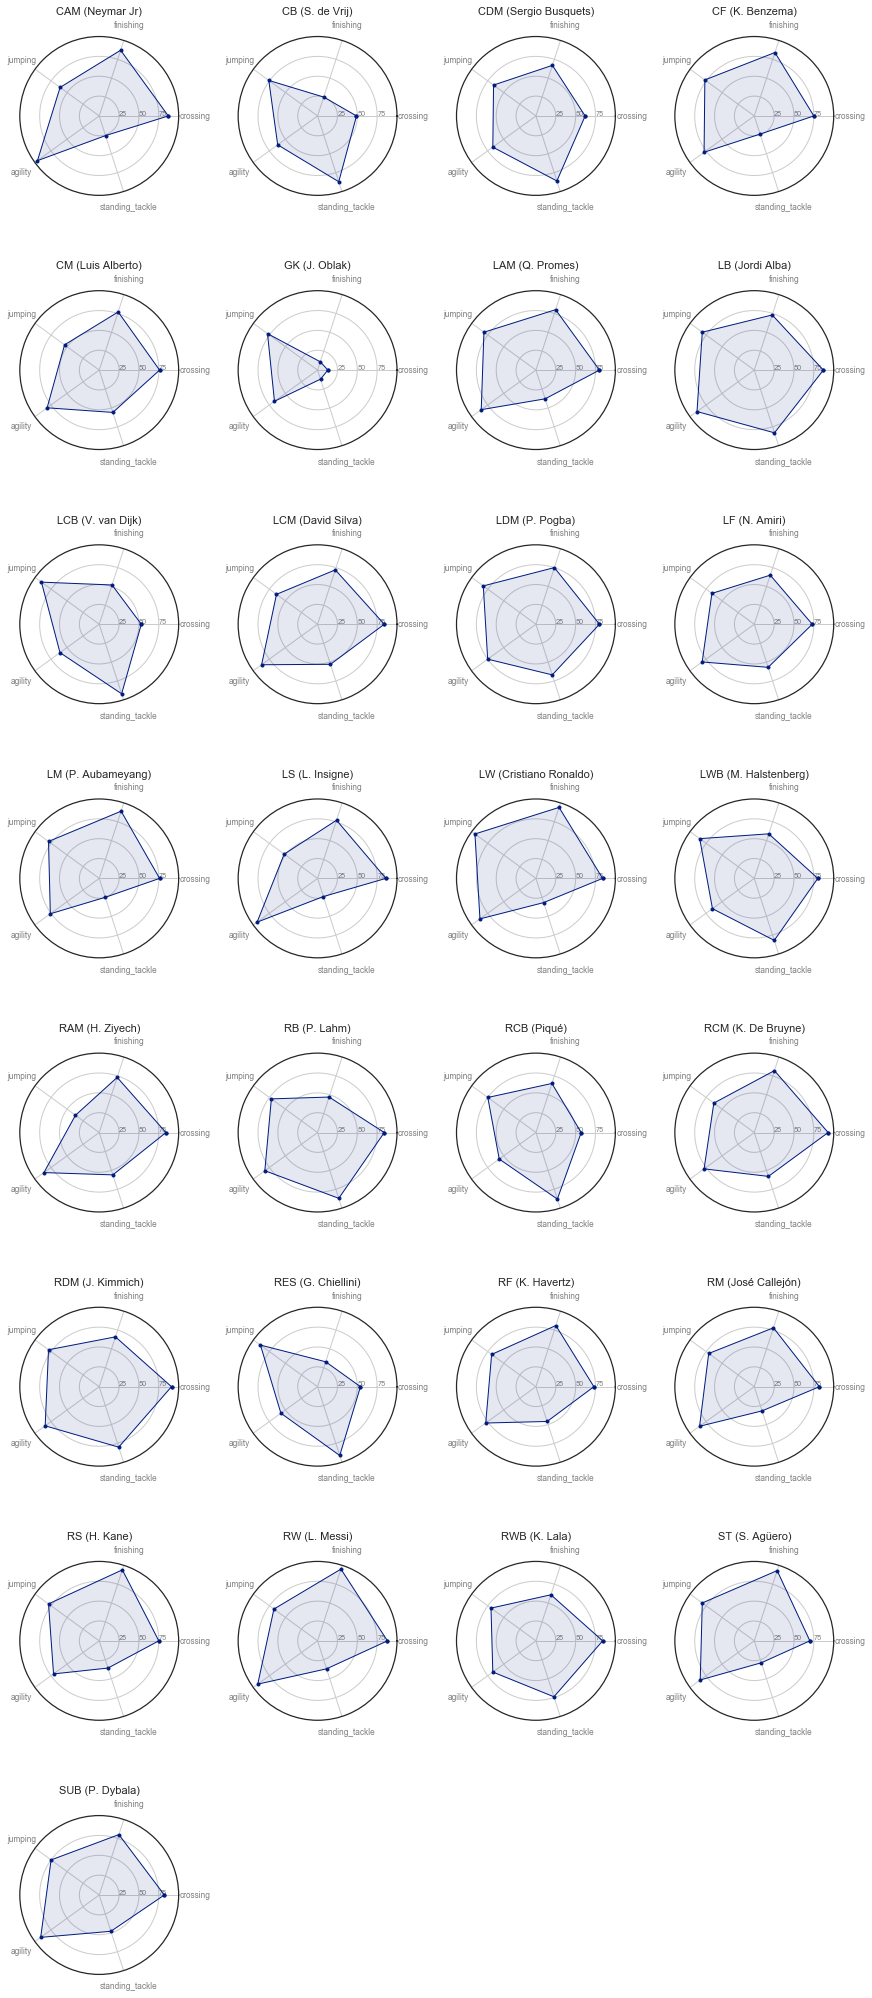

In [44]:
# Code to plot the radar plot for every player.
idx = 1
plt.figure(figsize=(15,45))
for position_name,attributes in top_player_extract.iterrows():
    Attributes = dict(attributes[2:])
    Categories = Attributes.keys()
    AttNo = len(Categories)
    values = list(Attributes.values())
    values += values[:1]
    angles = [n / float(AttNo) * 2 * 3.14 for n in range(AttNo)]
    angles += angles [:1]
    ax = plt.subplot(10,4,idx, polar=True)
    plt.xticks(angles[:-1], Attributes, color='grey', size=8.3)
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7.3)
    plt.ylim(0,100)
    plt.subplots_adjust(hspace = 0.6)
    ax.plot(angles, values, '.', linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.title(position_name+' '+'('+attributes[0]+')', size=11, y=1.1)
    idx += 1 

> It can be seen in the radar grpahs that how these top key attributes fluctuates as the position changes.

# Decision Making
In this section, we will be using KNN to predict the player position on which a player can play irrespective of their preferred position. Playing positions for which players will be predicted are:
- GK
- LCB
- RCB
- RCM
- LCM
- RM
- LM
- RW
- LW
- ST


## Clubbing positions
To reduce the number of classes to predict, we have clubbed similar positions to one group and to differentiate the features of different positions from one another, we have added weight to the original values.
E.g. For ST (Striker), features like ball_control, reactions, dribbling, acceleration, sprint_speed, shot_power, long_shots, heading_accuracy, finishing, volleys, strength are very important and a player should posses high rating in these features to be charaterised as ST, so we have incremented these values for training the model.

In [45]:
# SQL query to select player attributes to be used as features for knn.
sql_select_attributes = '''
SELECT
     a.player_id
    ,CASE WHEN c.club_playing_position IN ('LCM','RCM') THEN 'LCM/RCM'
          WHEN c.club_playing_position IN ('LW','RW') THEN 'LW/RW'
          WHEN c.club_playing_position IN ('LM','RM') THEN 'LM/RM'
          WHEN c.club_playing_position IN ('LCB','RCB') THEN 'LCB/RCB'
          ELSE c.club_playing_position
     END AS club_playing_position_grouped
    ,c.club_playing_position
    ,b.acceleration
    ,b.aggression
    ,b.agility
    ,b.ball_control
    ,b.crossing
    ,b.dribbling
    ,b.finishing
    ,b.heading_accuracy
    ,b.interceptions
    ,b.jumping
    ,b.long_passing
    ,b.long_shots
    ,b.reactions
    ,b.short_passing
    ,b.shot_power
    ,b.sliding_tackle
    ,b.sprint_speed
    ,b.stamina
    ,b.standing_tackle
    ,b.strength
    ,b.vision
    ,b.volleys
FROM player_personal_info a
INNER JOIN player_attributes_info b
    ON (a.player_id=b.player_id)
INNER JOIN player_club_info c
    ON (a.player_id=c.player_id)
WHERE c.club_playing_position IN ('LW','ST','RW','LM','LCM','RCM','RM','LCB','CB','RCB','GK')
;
'''

In [46]:
# Executing the sql statement and storing the result in a pandas dataframe
conn = create_connection(db_filename)
player_stats = read_sql_as_pandas_df(conn,sql_select_attributes)
conn.close()

# Dropping all the NaN records
player_stats = player_stats.dropna()

Distribution of players amongst different grouped playing positions.

In [47]:
# Insights of the data distribution over different classes
player_stats.groupby('club_playing_position_grouped').count()['player_id'].sort_values()

club_playing_position_grouped
CB           86
LW/RW       297
ST          435
GK          568
LCM/RCM     718
LM/RM       719
LCB/RCB    1146
Name: player_id, dtype: int64

##### Attributes groups for player's selection:

PACE
- Sprint Speed
- Acceleration

PASSING
- Short pass
- Crossing
- Vision
- Long Pass
- Curve
- Free Kick

DEFENDING
- Stand Tackle
- Marking
- Interceptions
- Heading Accuracy
- Slide Tackle

SHOOTING
- Finishing
- Long Shots
- Shot Power
- Volleys
- Positioning
- Penalties 

DRIBBLING 
- Dribbling
- Ball Control
- Agility
- Balance

PHYSICAL
- Strenght
- Stamina
- Aggression
- Jumping


Code to add weight to the features important for **'CB'** position. Below is the criteria:
- Standing Tackle  : 20%
- Sliding Tackle   : 20%
- Heading Accuracy : 15%
- Strength         : 10%
- Aggression       : 08%
- Interceptions    : 08%
- Short Passing    : 08%
- Ball Control     : 05%
- Reactions        : 05%
- Jumping          : 04%

In [48]:
# Selecting attributes for different player position and scaling up the values to add weight to particular features.
# CB
player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'standing_tackle'  ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'standing_tackle' ].apply(lambda x: x + (x * 0.20))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'sliding_tackle'   ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'sliding_tackle'  ].apply(lambda x: x + (x * 0.20))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'heading_accuracy' ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'heading_accuracy'].apply(lambda x: x + (x * 0.15))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'strength'         ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'strength'        ].apply(lambda x: x + (x * 0.10))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'aggression'       ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'aggression'      ].apply(lambda x: x + (x * 0.08))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'interceptions'    ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'interceptions'   ].apply(lambda x: x + (x * 0.08))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'short_passing'    ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'short_passing'   ].apply(lambda x: x + (x * 0.05))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'ball_control'     ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'ball_control'    ].apply(lambda x: x + (x * 0.05))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'reactions'        ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'reactions'       ].apply(lambda x: x + (x * 0.05))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'jumping'          ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'CB', 'jumping'         ].apply(lambda x: x + (x * 0.04))

Code to add weight to the features important for **'LCB/RCB'** position. Below is the criteria:

- Standing Tackle : 12%
- Sliding Tackle : 13%
- Heading Accuracy : 07%
- Aggression : 05%
- Interceptions : 12%
- Short Passing: 06%
- Ball Control : 07%
- Reactions : 13%
- Stamina : 13%
- Crossing : 07%
- Sprint Speed : 05%

In [49]:
# Selecting attributes for different player position and scaling up the values to add weight to particular features.
# LCB/RCB  
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'standing_tackle' ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'standing_tackle' ].apply(lambda x: x + (x * 0.12))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'sliding_tackle'  ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'sliding_tackle'  ].apply(lambda x: x + (x * 0.13))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'heading_accuracy'] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'heading_accuracy'].apply(lambda x: x + (x * 0.07))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'aggression'      ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'aggression'      ].apply(lambda x: x + (x * 0.05))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'interceptions'   ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'interceptions'   ].apply(lambda x: x + (x * 0.12))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'short_passing'   ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'short_passing'   ].apply(lambda x: x + (x * 0.06))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'ball_control'    ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'ball_control'    ].apply(lambda x: x + (x * 0.07))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'reactions'       ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'reactions'       ].apply(lambda x: x + (x * 0.13))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'stamina'         ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'stamina'         ].apply(lambda x: x + (x * 0.13))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'crossing'        ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'crossing'        ].apply(lambda x: x + (x * 0.07))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'sprint_speed'    ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCB/RCB', 'sprint_speed'    ].apply(lambda x: x + (x * 0.05))

Code to add weight to the features important for **'LM/RM'** position. Below is the criteria:
- Short Passing : 12%
- Ball Control : 15%
- Reactions : 11%
- Vision : 08%
- Dribbling : 14%
- Acceleration : 05%
- Agility : 03%
- Crossing : 14%
- Long Passing : 08%
- Stamina : 05%
- Sprint Speed : 05%

In [50]:
# Selecting attributes for different player position and scaling up the values to add weight to particular features.
# LM/RM  
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'short_passing'] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'short_passing'].apply(lambda x: x + (x * 0.12))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'ball_control' ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'ball_control' ].apply(lambda x: x + (x * 0.15))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'reactions'    ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'reactions'    ].apply(lambda x: x + (x * 0.11))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'vision'       ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'vision'       ].apply(lambda x: x + (x * 0.08))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'dribbling'    ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'dribbling'    ].apply(lambda x: x + (x * 0.14))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'acceleration' ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'acceleration' ].apply(lambda x: x + (x * 0.05))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'agility'      ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'agility'      ].apply(lambda x: x + (x * 0.03))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'crossing'     ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'crossing'     ].apply(lambda x: x + (x * 0.14))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'long_passing' ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'long_passing' ].apply(lambda x: x + (x * 0.08))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'stamina'      ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'stamina'      ].apply(lambda x: x + (x * 0.05))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'sprint_speed' ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LM/RM', 'sprint_speed' ].apply(lambda x: x + (x * 0.05))

Code to add weight to the features important for **'LCM/RCM'** position. Below is the criteria:
- Standing Tackle : 10%
- Interceptions : 12%
- Short Passing : 15%
- Ball Control : 10% 
- Reactions : 08%
- Stamina : 06%
- Long Passing : 13%
- Vision : 12%
- Dribbling : 09%
- Long Shots : 05%

In [51]:
# Selecting attributes for different player position and scaling up the values to add weight to particular features.
#LCM/RCM
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'standing_tackle' ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'standing_tackle' ].apply(lambda x: x + (x * 0.10))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'interceptions'   ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'interceptions'   ].apply(lambda x: x + (x * 0.12))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'short_passing'   ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'short_passing'   ].apply(lambda x: x + (x * 0.15))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'ball_control'    ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'ball_control'    ].apply(lambda x: x + (x * 0.10))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'reactions'       ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'reactions'       ].apply(lambda x: x + (x * 0.08))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'stamina'         ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'stamina'         ].apply(lambda x: x + (x * 0.06))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'long_passing'    ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'long_passing'    ].apply(lambda x: x + (x * 0.13))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'vision'          ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'vision'          ].apply(lambda x: x + (x * 0.12))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'dribbling'       ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'dribbling'       ].apply(lambda x: x + (x * 0.09))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'long_shots'      ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LCM/RCM', 'long_shots'      ].apply(lambda x: x + (x * 0.05))

Code to add weight to the features important for **'LW/RW'** position. Below is the criteria:
- Short Passing : 12%
- Ball Control : 11%
- Reactions : 16%
- Vision : 05%
- Dribbling : 11%
- Acceleration : 04%
- Sprint Speed : 04%
- Shot Power : 10%
- Long Shots : 10%
- Heading Accuracy : 05%
- Crossing : 16%

In [52]:
# Selecting attributes for different player position and scaling up the values to add weight to particular features.
# LW/RW  
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'short_passing'   ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'short_passing'   ].apply(lambda x: x + (x * 0.12))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'ball_control'    ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'ball_control'    ].apply(lambda x: x + (x * 0.11))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'reactions'       ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'reactions'       ].apply(lambda x: x + (x * 0.16))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'vision'          ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'vision'          ].apply(lambda x: x + (x * 0.05))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'dribbling'       ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'dribbling'       ].apply(lambda x: x + (x * 0.11))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'acceleration'    ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'acceleration'    ].apply(lambda x: x + (x * 0.04))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'sprint_speed'    ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'sprint_speed'    ].apply(lambda x: x + (x * 0.04))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'shot_power'      ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'shot_power'      ].apply(lambda x: x + (x * 0.10))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'long_shots'      ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'long_shots'      ].apply(lambda x: x + (x * 0.10))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'heading_accuracy'] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'heading_accuracy'].apply(lambda x: x + (x * 0.05))
player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'crossing'        ] = player_stats.loc[player_stats['club_playing_position_grouped'] == 'LW/RW', 'crossing'        ].apply(lambda x: x + (x * 0.16))

Code to add weight to the features important for **'ST'** position. Below is the criteria:
- Ball Control : 14%
- Reactions : 10%
- Dribbling : 08%
- Acceleration : 11%
- Sprint Speed : 04%
- Shot Power : 10%
- Long Shots : 05%
- Heading Accuracy : 10%
- Finishing : 20%
- Volleys : 05%
- Strength : 03%

In [53]:
# Selecting attributes for different player position and scaling up the values to add weight to particular features.
# ST
player_stats.loc[player_stats['club_playing_position'] == 'ST', 'ball_control'    ] = player_stats.loc[player_stats['club_playing_position'] == 'ST', 'ball_control'    ].apply(lambda x: x + (x * 0.14))
player_stats.loc[player_stats['club_playing_position'] == 'ST', 'reactions'       ] = player_stats.loc[player_stats['club_playing_position'] == 'ST', 'reactions'       ].apply(lambda x: x + (x * 0.10))
player_stats.loc[player_stats['club_playing_position'] == 'ST', 'dribbling'       ] = player_stats.loc[player_stats['club_playing_position'] == 'ST', 'dribbling'       ].apply(lambda x: x + (x * 0.08))
player_stats.loc[player_stats['club_playing_position'] == 'ST', 'acceleration'    ] = player_stats.loc[player_stats['club_playing_position'] == 'ST', 'acceleration'    ].apply(lambda x: x + (x * 0.11))
player_stats.loc[player_stats['club_playing_position'] == 'ST', 'sprint_speed'    ] = player_stats.loc[player_stats['club_playing_position'] == 'ST', 'sprint_speed'    ].apply(lambda x: x + (x * 0.04))
player_stats.loc[player_stats['club_playing_position'] == 'ST', 'shot_power'      ] = player_stats.loc[player_stats['club_playing_position'] == 'ST', 'shot_power'      ].apply(lambda x: x + (x * 0.10))
player_stats.loc[player_stats['club_playing_position'] == 'ST', 'long_shots'      ] = player_stats.loc[player_stats['club_playing_position'] == 'ST', 'long_shots'      ].apply(lambda x: x + (x * 0.05))
player_stats.loc[player_stats['club_playing_position'] == 'ST', 'heading_accuracy'] = player_stats.loc[player_stats['club_playing_position'] == 'ST', 'heading_accuracy'].apply(lambda x: x + (x * 0.10))
player_stats.loc[player_stats['club_playing_position'] == 'ST', 'finishing'       ] = player_stats.loc[player_stats['club_playing_position'] == 'ST', 'finishing'       ].apply(lambda x: x + (x * 0.20))
player_stats.loc[player_stats['club_playing_position'] == 'ST', 'volleys'         ] = player_stats.loc[player_stats['club_playing_position'] == 'ST', 'volleys'         ].apply(lambda x: x + (x * 0.05))
player_stats.loc[player_stats['club_playing_position'] == 'ST', 'strength'        ] = player_stats.loc[player_stats['club_playing_position'] == 'ST', 'strength'        ].apply(lambda x: x + (x * 0.03))

Extracting classes and features from the dataset for feeding into KNN

In [54]:
# Segregating features and classes from the pandas dataframe
# Contains all the features for KNN
X_features = player_stats.iloc[:,3:]
y_class = player_stats.iloc[:,1]

In [55]:
# Assigning numeric values to the different classes
map_position = {'CB':1, 'LW/RW':2, 'ST':3, 'GK':4, 'LCM/RCM':5, 'LM/RM':6, 'LCB/RCB':7}
y_class = y_class.replace({'club_playing_position_grouped' : map_position})

In [56]:
# Converting features and classes pandas dataframe to ndarray
X = X_features.to_numpy()
y = y_class.to_numpy().ravel()

In [57]:
# Applying KNN on thr data and finding the accuracy for mulitple values of k ranging from 1 to 26.
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_range= range(1,26)
scores = {}
scores_list=[]

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    y_predicted_position = knn.predict(X)
    scores[k] = metrics.accuracy_score(y, y_predicted_position)
    scores_list.append(metrics.accuracy_score(y,y_predicted_position))

Text(0, 0.5, 'Accuracy')

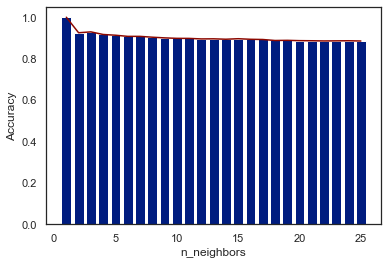

In [58]:
# Plotting the values of the accuracy for the multiple values of k
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(k_range,scores_list, color='r')
plt.bar(k_range,scores_list)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')

In [59]:
# Setting the value of n_neighbour.
k_neighbour = 7

In [60]:
# Test Error
X_train, X_test, y_train, y_test = train_test_split(X, y)
knn = KNeighborsClassifier(n_neighbors = k_neighbour)
knn.fit(X_train, y_train)
print("Training error =", zero_one_loss(y_train, knn.predict(X_train)))
print("Test error =", zero_one_loss(y_test, knn.predict(X_test)))

Training error = 0.09509408602150538
Test error = 0.11581067472306139


In [61]:
# K-Fold Test
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
scores = cross_val_score(KNeighborsClassifier(n_neighbors=k_neighbour), X, y, 
                         cv=KFold(n_splits=5, random_state=42), 
                         scoring="accuracy")
print("CV error = %f +-%f" % (1. - np.mean(scores), np.std(scores)))

CV error = 0.120943 +-0.021380


## Predicting positions
Extracting all players data to predict their new positions

In [62]:
# Extracting all players information to predict their positions.
sql_extract_all_players = '''
SELECT
     a.player_id
    ,b.gk_diving
    ,b.gk_handling
    ,b.gk_positioning
    ,b.gk_reflexes
    ,b.gk_kicking
    ,CASE WHEN c.club_playing_position IN ('LCM','RCM') THEN 'LCM/RCM'
          WHEN c.club_playing_position IN ('LW','RW') THEN 'LW/RW'
          WHEN c.club_playing_position IN ('LM','RM') THEN 'LM/RM'
          WHEN c.club_playing_position IN ('LCB','RCB') THEN 'LCB/RCB'
          ELSE c.club_playing_position
     END AS club_playing_position_grouped
    ,c.club_playing_position
    ,b.acceleration
    ,b.aggression
    ,b.agility
    ,b.ball_control
    ,b.crossing
    ,b.dribbling
    ,b.finishing
    ,b.heading_accuracy
    ,b.interceptions
    ,b.jumping
    ,b.long_passing
    ,b.long_shots
    ,b.reactions
    ,b.short_passing
    ,b.shot_power
    ,b.sliding_tackle
    ,b.sprint_speed
    ,b.stamina
    ,b.standing_tackle
    ,b.strength
    ,b.vision
    ,b.volleys
FROM player_personal_info a
INNER JOIN player_attributes_info b
    ON (a.player_id=b.player_id)
INNER JOIN player_club_info c
    ON (a.player_id=c.player_id)
;
'''

In [63]:
# Executing the sql statement and storing the result in a pandas dataframe
conn = create_connection(db_filename)
all_player_stats = read_sql_as_pandas_df(conn,sql_extract_all_players)
conn.close()
# Dropping all the NaN records
all_player_stats = all_player_stats.dropna()

In [64]:
# Extracting the attributes for all players for predicting their position
X_predict = all_player_stats.iloc[:,8:].to_numpy()

In [65]:
# Feeding the feature list into the model to get the predicted position
all_player_stats['club_playing_position_predicted']=knn.predict(X_predict)

In [66]:
# Converting the predicted numerical values to the actual position
map_position_inverted = mapping = {1:'CB', 2:'LW/RW', 3:'ST', 4:'GK', 5:'LCM/RCM', 6:'LM/RM', 7:'LCB/RCB'}
all_player_stats = all_player_stats.replace({'club_playing_position_predicted':map_position_inverted})

### Predicted positions vs preferred positions

In [67]:
# Showing how the club_playing_position are distributed amongst the predicted positions
pd.set_option('display.max_rows', 500)
all_player_stats.groupby(['club_playing_position','club_playing_position_predicted']).count()[['player_id']]

player_id
club_playing_position club_playing_position_predicted           
CAM                   LCB/RCB                                  3
                      LCM/RCM                                124
                      LM/RM                                  155
                      LW/RW                                   10
                      ST                                      14
CB                    LCB/RCB                                 83
                      LCM/RCM                                  3
CDM                   LCB/RCB                                 34
                      LCM/RCM                                 97
                      LM/RM                                    3
CF                    LCM/RCM                                  3
                      LM/RM                                    6
                      LW/RW                                    1
                      ST                                       1
CM                    LCB/RCB                                  9
                      LCM/RCM                                 61
                      LM/RM                                    5
GK                    GK                                     555
LAM                   LCM/RCM                                  6
                      LM/RM                                   14
                      LW/RW                                    2
                      ST                                       2
LB                    CB                                       1
                      LCB/RCB                                239
                      LCM/RCM                                110
                      LM/RM                                  115
LCB                   LCB/RCB                                555
                      LCM/RCM                                 22
                      LM/RM                                    1
                      LW/RW                                    1
LCM                   LCB/RCB                                 17
                      LCM/RCM                                289
                      LM/RM                                   46
                      LW/RW                                    3
                      ST                                       3
LDM                   LCB/RCB                                 37
                      LCM/RCM                                157
                      LM/RM                                    9
LF                    LCM/RCM                                  1
                      LM/RM                                   13
                      LW/RW                                    1
                      ST                                       2
LM                    LCB/RCB                                 10
                      LCM/RCM                                 41
                      LM/RM                                  282
                      LW/RW                                   25
                      ST                                      20
LS                    LCM/RCM                                  7
                      LM/RM                                   69
                      LW/RW                                   15
                      ST                                     115
LW                    LCM/RCM                                 11
                      LM/RM                                  103
                      LW/RW                                   25
                      ST                                       8
LWB                   LCB/RCB                                 24
                      LCM/RCM                                 12
                      LM/RM                                   13
                      LW/RW                                    1
RAM                   LCM/RCM                                  6
                      LM/

### Calculating weighted points for every player as per the predicted position. 
*(Using the same weightage points as mentioned above)*

In [68]:
# Calculating columns with the weighted score.
def player_weighted_points(row):
    if row['club_playing_position_predicted']=='GK':
        return (0.24*row['gk_diving']+0.22*row['gk_handling']+0.22*row['gk_positioning']+0.22*row['gk_reflexes'] +0.06*row['reactions']+0.04*row['gk_kicking'])/10
    elif row['club_playing_position_predicted']=='CB':
        return (0.20*row['standing_tackle']+0.20*row['sliding_tackle']+0.15*row['heading_accuracy']+0.10*row['strength'] +0.08*row['aggression']+0.08*row['interceptions']+0.05*row['short_passing']+0.05*row['ball_control']+0.05*row['reactions']+0.04*row['jumping'])/10
    elif row['club_playing_position_predicted']=='LCB/RCB':
        return (0.12*row['standing_tackle']+0.13*row['sliding_tackle']+0.07*row['heading_accuracy']+0.05*row['aggression']+0.12*row['interceptions']+0.06*row['short_passing']+0.07*row['ball_control']+0.13*row['reactions']+0.13*row['stamina']+0.07*row['crossing']+0.05*row['sprint_speed'])/10
    elif row['club_playing_position_predicted']=='LM/RM':
        return (0.12*row['short_passing']+0.15*row['ball_control']+0.11*row['reactions']+0.08*row['vision']+ 0.14*row['dribbling'] + 0.05*row['acceleration'] + 0.03*row['agility'] + 0.14*row['crossing'] + 0.08*row['long_passing'] + 0.05*row['stamina']+0.05*row['sprint_speed'])/10
    elif row['club_playing_position_predicted']=='LCM/RCM':
        return (0.10*row['standing_tackle']+0.12*row['interceptions']+0.15*row['short_passing']+0.10*row['ball_control']+0.08*row['reactions']+0.06*row['stamina']+ 0.13*row['long_passing'] +0.12*row['vision']+ 0.09*row['dribbling'] + 0.05*row['long_shots'])/10
    elif row['club_playing_position_predicted']=='LW/RW':
        return (0.12*row['short_passing']+0.11*row['ball_control']+0.16*row['reactions']+0.05*row['vision']+ 0.11*row['dribbling'] + 0.04*row['acceleration']  + 0.04*row['sprint_speed'] + 0.10*row['shot_power']+ 0.10*row['long_shots'] + 0.05*row['heading_accuracy'] +0.16*row['crossing'])/10
    elif row['club_playing_position_predicted']=='ST':
        return (0.14*row['ball_control']+0.10*row['reactions']+ 0.08*row['dribbling'] + 0.11*row['acceleration']  + 0.04*row['sprint_speed'] + 0.10*row['shot_power']+ 0.05*row['long_shots'] + 0.10*row['heading_accuracy'] + 0.20*row['finishing'] + 0.05*row['volleys']+0.03*row['strength'])/10

In [69]:
# Applying the function on the predicted values and calculating the values.
all_player_stats['player_points'] = all_player_stats.apply(player_weighted_points, axis=1)

## Team Formation using PuLP module (Linear Programming)

Following 3 teams will be built in 3-4-3 formation using Optimizer:
- Balanced
- Attacking
- Defensive

Overall aim is to achieve the score of 84 while building the team. Team will be divided into 4 groups : {Forward, Mid, Back, GK} 

| Position Group | Balanced | Attacking | Defensive |
|----------------|----------|-----------|-----------|
| GK             | 8        | 7         | 8.8       |
| BACK           | 23       | 21        | 23        |
| MID            | 30       | 29        | 30        |
| FORWARD        | 23       | 27        | 22.2      |

Note : Need to install PuLP using below command:
pip install pulp

In [70]:
team_prediction = all_player_stats[['player_id', 'club_playing_position_predicted', 'player_points']]

### Linear eqaution for each group

```textile
BACK:
Maximize Eq:
LCB + CB + RCB == BACK_SCORE

Constraint:
LCB + CB <= LEFT_SCORE
CB + RCB <= RIGHT_SCORE
LCB + RCB <= CENTER_SCORE

MID:
Maximize Eq:
LM + LCM + RCM + RM == MID_SCORE

Constraint:
LM + LCM <= LEFT_SCORE
RM + RCM <= RIGHT_SCORE
LCM + RCM <= CENTER_SCORE
LM + RM <= MID_END_SCORE

FORWARD:
Maximize Eq:
LW + ST + RW == FORWARD_SCORE

Constraint:
LW + ST <= LEFT_SCORE
ST + RW <= RIGHT_SCORE
LW + RW <= CENTER_SCORE
```


In [71]:
import pulp 

def get_rating(low_score, high_score, left_score, center_score, right_score, lp_low, lp_high, cp_low, cp_high, rp_low, rp_high, mid_score=None, sd_low=None, sd_high=None):
    
    position = pulp.LpProblem("position", pulp.LpMaximize)
    score = pulp.LpVariable('score', lowBound=low_score, upBound=high_score, cat='Continuous')

    left = pulp.LpVariable('left', upBound=left_score, cat='Continuous')
    center = pulp.LpVariable('centre', upBound=center_score, cat='Continuous')
    right = pulp.LpVariable('right', upBound=right_score, cat='Continuous')
    mid = pulp.LpVariable('mid', upBound=mid_score, cat='Continuous')
    
    lp = pulp.LpVariable('lp', lowBound=lp_low, upBound=lp_high, cat='Continuous')
    cp = pulp.LpVariable('cp', lowBound=cp_low, upBound=cp_high, cat='Continuous')
    rp = pulp.LpVariable('rp', lowBound=rp_low, upBound=rp_high, cat='Continuous')
    sd = pulp.LpVariable('sd', lowBound=sd_low, upBound=sd_high, cat='Continuous')
    
    if mid_score is None:
        #Back: LCB = lp; CB = cp; RCB = rp
        #Forward: LW = lp; ST = cp; RW = rp
        position += lp + cp + rp, "score"
        position += lp + cp + rp == score
        position += lp + cp <= left
        position += cp + rp <= right
        position += lp + rp <= center
        position.solve()
        return lp.varValue, cp.varValue, rp.varValue    
    else:
        #LM = lp; LCM = cp; RCM = rp; RM = sd
        position += lp + cp + rp + sd, "score"
        position += lp + cp + rp + sd == score
        position += lp + cp <= left
        position += rp + sd <= right
        position += cp + rp <= center
        position += lp + sd <= mid
        position.solve()
        return lp.varValue, cp.varValue, rp.varValue, sd.varValue
    

In [72]:
def get_player_id(df, position, position_value):
    position_dict = {'LCM':'LCM/RCM', 'RCM':'LCM/RCM', 'LM':'LM/RM', 'RM':'LM/RM', 'LCB':'LCB/RCB', 'RCB':'LCB/RCB', 'ST':'ST', 'GK':'GK', 'LW':'LW/RW', 'RW':'LW/RW', 'CB':'CB'}
    return df[(df['club_playing_position_predicted'] == position_dict.get(position)) & (df['player_points'] >= position_value)].sort_values('player_points').iloc[0].player_id

In [73]:
# Balanced
def balanced_team():
    GK = 8.0
    LCB, CB, RCB = get_rating(20, 23, 18, 16, 17, 6.5, 8.5, 6.5, 7.5, 6.5, 7.8)
    LM, LCM, RCM, RM = get_rating(28, 30, 16, 18, 17, 7.0, 9.0, 6.8, 8.0, 7.0, 8.5, 15.5, 6.5, 7.9)
    LW, ST, RW = get_rating(20, 23, 17, 15, 17.5, 6.8, 7.5, 7.5, 8.8, 6.5, 7.8)
    return {'GK':GK, 'LCB':LCB, 'CB':CB, 'RCB': RCB, 'LM':LM, 'LCM':LCM, 'RCM':RCM, 'RM':RM, 'LW':LW, 'ST':ST, 'RW':RW}

In [74]:
# Attacking
def attacking_team():
    GK = 7.0
    LCB, CB, RCB = get_rating(19, 21, 15, 14.5, 14, 6.5, 7.5, 6.5, 8.0, 6.5, 7.5)
    LM, LCM, RCM, RM = get_rating(26, 29, 15, 15, 14.5, 6.5, 7.5, 7.0, 8.0, 7.0, 8.0, 14, 6.5, 7.5)
    LW, ST, RW = get_rating(25, 27, 19, 19, 18.5, 7.5, 9.4, 7.0, 8.5, 7.0, 9.2)
    return {'GK':GK, 'LCB':LCB, 'CB':CB, 'RCB': RCB, 'LM':LM, 'LCM':LCM, 'RCM':RCM, 'RM':RM, 'LW':LW, 'ST':ST, 'RW':RW}

In [75]:
# Defensive
def defensive_team():
    GK = 8.8
    LCB, CB, RCB = get_rating(20, 23, 17, 16, 18, 7.0, 8.4, 6.0, 7.3, 7.0, 8.2)
    LM, LCM, RCM, RM = get_rating(25, 30, 17, 16, 15.5, 6.5, 8.5, 7.0, 8.5, 7.0, 8.0, 15.5, 6.5, 8.0)
    LW, ST, RW = get_rating(19, 22.2, 15, 15.5, 14, 6.5, 8.5, 6.5, 8.0, 6.5, 7.5)
    return {'GK':GK, 'LCB':LCB, 'CB':CB, 'RCB': RCB, 'LM':LM, 'LCM':LCM, 'RCM':RCM, 'RM':RM, 'LW':LW, 'ST':ST, 'RW':RW}

In [76]:
# SQL statement to select player personal information
sql_player_profile_url = '''
SELECT
     player_id
    ,player_name
    ,player_nationality
    ,player_photo_url
FROM player_personal_info
;
'''

In [77]:
# Executing the sql statement and storing the result in a pandas dataframe
conn = create_connection(db_filename)
player_info_df = read_sql_as_pandas_df(conn,sql_player_profile_url)
conn.close()

# Image Processing
In this section, final predicted teams will be displayed over a football field image with player images overlayed on it.

In [78]:
# Code to generate the football field image along with the overlayed player images fetched from the player urls.
# Dictionary containing the coordinates as per the player position.
p_coordinates = {'ST'  : {'P_Image':(234,65) ,'P_Label':(278, 53)},
                 'LW'  : {'P_Image':(143,105),'P_Label':(180, 90)},
                 'RW'  : {'P_Image':(326,105),'P_Label':(362, 90)},
                 'LM'  : {'P_Image':(51,251) ,'P_Label':(93, 235)},
                 'RM'  : {'P_Image':(430,251),'P_Label':(467, 235)},
                 'LCM' : {'P_Image':(170,288),'P_Label':(202, 273)},
                 'RCM' : {'P_Image':(302,288),'P_Label':(337, 273)},
                 'LCB' : {'P_Image':(142,459),'P_Label':(177, 445)},
                 'RCB' : {'P_Image':(345,459),'P_Label':(383, 445)},
                 'CB'  : {'P_Image':(244,459),'P_Label':(285, 445)},
                 'GK'  : {'P_Image':(242,581),'P_Label':(285, 695)}}

# Function to generate the processed field image with players images overlayed.
def generate_field_image(p_url_dict, p_coordinates=p_coordinates):
    
    nan_player_url = 'https://cdn.sofifa.org/players/10/notfound_0@2x.png'
    background = Image.open("formation.png")
    draw = ImageDraw.Draw(background)
    font = ImageFont.truetype('Raleway-ExtraBold.ttf', size=20)
    
    for position, url in p_url_dict.items():
        try:
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
        except:
            response = requests.get(nan_player_url)
            img = Image.open(BytesIO(response.content))            
        img.thumbnail((111,111), Image.ANTIALIAS)
        background.paste(img, p_coordinates[position]['P_Image'], img)
        draw.text(p_coordinates[position]['P_Label'],position,(255,255,255),align='center', font=font)
    
    return background

## Balanced Team

In [79]:
team_ratings = balanced_team()

team_position = {}

for k in team_ratings.keys():
    team_position[k] = get_player_id(team_prediction, k, team_ratings.get(k))

In [80]:
# Looping over the team positions and getting the player name and player profile pic url from the player_info_df dataframe
player_url_dict = {}
playing_11 = {}
for key, value in team_position.items():
    player_url_dict[key] = player_info_df[player_info_df['player_id'] == value].iloc[0].player_photo_url
    playing_11[key] = player_info_df[player_info_df['player_id'] == value].iloc[0].player_name

In [83]:
# Calling function to generate the field image.
balanced_team = generate_field_image(player_url_dict)

In [84]:
# Display the player names as per the position
pd.DataFrame(list(playing_11.items()), columns=['Position', 'Player Name'])

,Position,Player Name
0,GK,M. Landreau
1,LCB,K. Walker
2,CB,M. Diouf
3,RCB,Bartra
4,LM,H. Duljević
5,LCM,I. Rossi
6,RCM,M. Verratti
7,RM,F. Mollet
8,LW,C. Chávez
9,ST,S. Haller


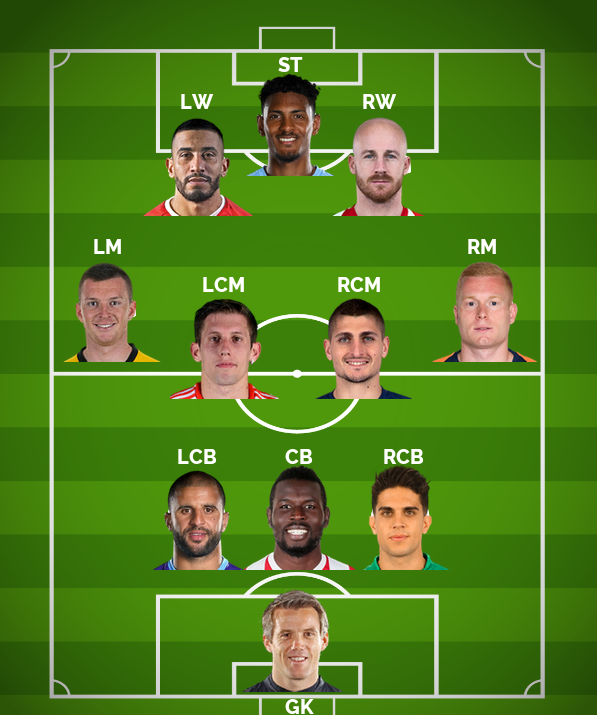

In [85]:
balanced_team

## Attacking Team

In [86]:
team_ratings = attacking_team()

team_position = {}

for k in team_ratings.keys():
    team_position[k] = get_player_id(team_prediction, k, team_ratings.get(k))


In [87]:
# Looping over the team positions and getting the player name and player profile pic url from the player_info_df dataframe
player_url_dict = {}
playing_11 = {}
for key, value in team_position.items():
    player_url_dict[key] = player_info_df[player_info_df['player_id'] == value].iloc[0].player_photo_url
    playing_11[key] = player_info_df[player_info_df['player_id'] == value].iloc[0].player_name

In [88]:
# Calling function to generate the field image.
attacking_team = generate_field_image(player_url_dict)

In [89]:
# Display the player names as per the position
pd.DataFrame(list(playing_11.items()), columns=['Position', 'Player Name'])

,Position,Player Name
0,GK,J. Siebenhandl
1,LCB,A. Espino
2,CB,J. Watson
3,RCB,L. Koscielny
4,LM,S. Pienaar
5,LCM,K. Kerschbaumer
6,RCM,K. Kampl
7,RM,M. Njie
8,LW,L. Messi
9,ST,E. Cavani


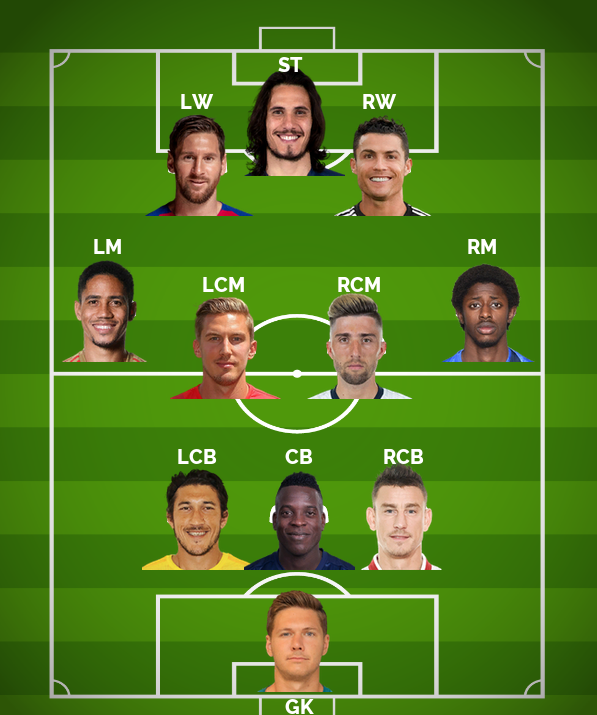

In [90]:
attacking_team

## Defensive Team

In [91]:
team_ratings = defensive_team()

team_position = {}

for k in team_ratings.keys():
    team_position[k] = get_player_id(team_prediction, k, team_ratings.get(k))


In [92]:
# Looping over the team positions and getting the player name and player profile pic url from the player_info_df dataframe
player_url_dict = {}
playing_11 = {}
for key, value in team_position.items():
    player_url_dict[key] = player_info_df[player_info_df['player_id'] == value].iloc[0].player_photo_url
    playing_11[key] = player_info_df[player_info_df['player_id'] == value].iloc[0].player_name

In [93]:
# Calling function to generate the field image.
defensive_team = generate_field_image(player_url_dict)

In [94]:
# Display the player names as per the position
pd.DataFrame(list(playing_11.items()), columns=['Position', 'Player Name'])

,Position,Player Name
0,GK,J. Oblak
1,LCB,Bartra
2,CB,M. Diouf
3,RCB,K. Walker
4,LM,J. Kimmich
5,LCM,K. Kampl
6,RCM,K. Kerschbaumer
7,RM,M. Njie
8,LW,A. Sánchez
9,ST,R. Mühren


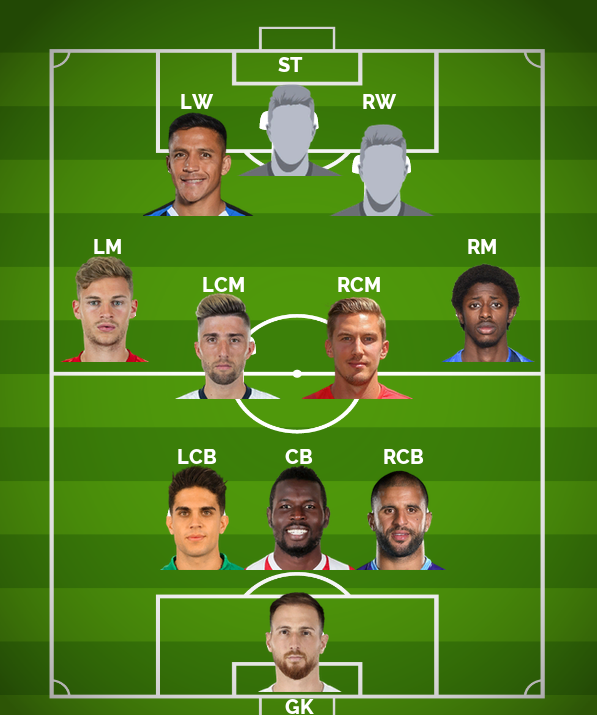

In [95]:
defensive_team